# TODO: Average posteriors!!!

In [1]:
%matplotlib notebook
from __future__ import division
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from schlichtanders.mymatplotlib import Centre
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
import pandas as pd
import numpy as np
import theano
import theano.tensor as T
import theano_models as tm
import theano_models.deterministic_models as dm
import theano_models.probabilistic_models as pm

In [3]:
from experiment_toy_models import toy_likelihood

In [4]:
from schlichtanders.myfunctools import meanexp

In [5]:
toy1d = toy_likelihood(1)
toy2d = toy_likelihood(2)

toy1d_sampler = theano.function([], toy1d['outputs'])
toy2d_sampler = theano.function([], toy2d['outputs'])

toy1d_lik = theano.function(toy1d.logP['inputs'] + toy1d['inputs'], toy1d.logP['outputs'])
toy2d_lik = theano.function(toy2d.logP['inputs'] + toy2d['inputs'], toy2d.logP['outputs'])

In [6]:
toy1d

Merge2 { 'inputs': [TensorConstant{(1,) of 0.0}], 'outputs': GaussianNoise.outputs}

In [7]:
def make_prior(targets):
    total_size = tm.total_size(targets['inputs'])
    return tm.fix_params(pm.DiagGauss(output_size=total_size))
prior1 = make_prior(toy1d)
prior2 = make_prior(toy2d)

prior1_sampler = prior1.function()
prior2_sampler = prior2.function()

prior1_logP = prior1.logP.function()
prior2_logP = prior2.logP.function()

Samples

In [8]:
# n_samples = 1000
n_samples = 800  # 80% training data, however we need to average this over multiple trials
toy1d_samples = [toy1d_sampler() for _ in xrange(n_samples)]
toy2d_samples = [toy2d_sampler() for _ in xrange(n_samples)]

overall log likelihood of sample is simple sum

In [9]:
def sample_lik1(w):
    return sum(toy1d_lik(s, w) for s in toy1d_samples)

def sample_lik2(w):
    return sum(toy2d_lik(s, w) for s in toy2d_samples)

In [10]:
normalizing_samples = 10000

normalizing_constant1 = meanexp([sample_lik1(prior1_sampler()) for _ in xrange(normalizing_samples)])
normalizing_constant2 = meanexp([sample_lik2(prior2_sampler()) for _ in xrange(normalizing_samples)])

In [11]:
@np.vectorize
def posterior1(w):
    return sample_lik1([w]) + prior1_logP([w]) - normalizing_constant1
    
@np.vectorize
def posterior2(w1, w2):
    return sample_lik2([w1, w2]) + prior2_logP([w1, w2]) - normalizing_constant2

In [22]:
ws = np.linspace(-5.5, 5.5, 200)
num_posterior1 = posterior1(ws)

In [13]:
_ws = np.linspace(-1.5, 1.5, 100)
W1, W2 = np.meshgrid(_ws, _ws)
num_posterior2 = posterior2(W1, W2)

In [14]:
num_posterior2

array([[ -5.15051395e+04,  -4.21474114e+04,  -3.46469948e+04, ...,
         -1.67825009e+03,  -4.75039464e+02,   9.32894480e-01],
       [ -4.94257622e+04,  -4.02684199e+04,  -3.29453611e+04, ...,
         -1.32025455e+03,  -2.94401705e+02,  -1.88151367e+01],
       [ -4.73892279e+04,  -3.84322714e+04,  -3.12865703e+04, ...,
         -1.00510206e+03,  -1.56606987e+02,  -8.14062094e+01],
       ..., 
       [ -8.77328210e+01,  -1.48136867e+02,  -9.83535626e+02, ...,
         -3.11657880e+04,  -3.82983927e+04,  -4.72405525e+04],
       [ -2.19784425e+01,  -2.82768279e+02,  -1.29552481e+03, ...,
         -3.28214154e+04,  -4.01313779e+04,  -4.92739235e+04],
       [  9.32894480e-01,  -4.60242733e+02,  -1.65035704e+03, ...,
         -3.45198859e+04,  -4.20072062e+04,  -5.13501375e+04]])

<IPython.core.display.Javascript object>


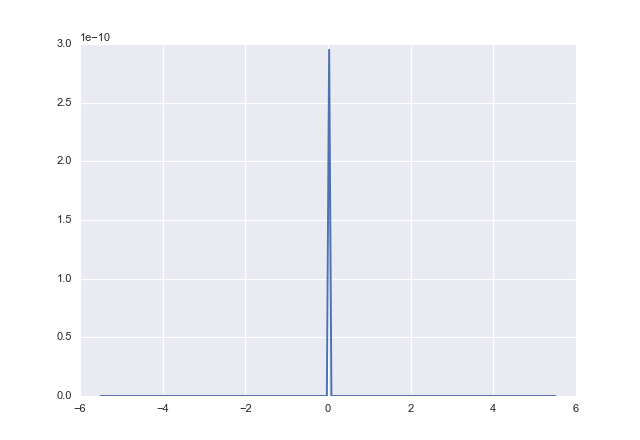

In [23]:
plt.figure()
plt.plot(ws, np.exp(num_posterior1))

In [18]:
plt.figure()
plt.contourf(W1, W2, np.exp(num_posterior2), norm=LogNorm())
# plt.colorbar()

<IPython.core.display.Javascript object>

ValueError: Contour levels must be increasing

<IPython.core.display.Javascript object>


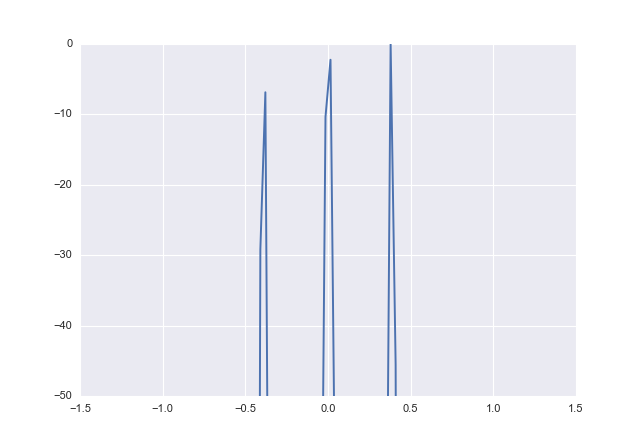

(-50, 0)

In [19]:
plt.figure()
plt.plot(ws, num_posterior1)
plt.ylim([-50, 0])

<IPython.core.display.Javascript object>


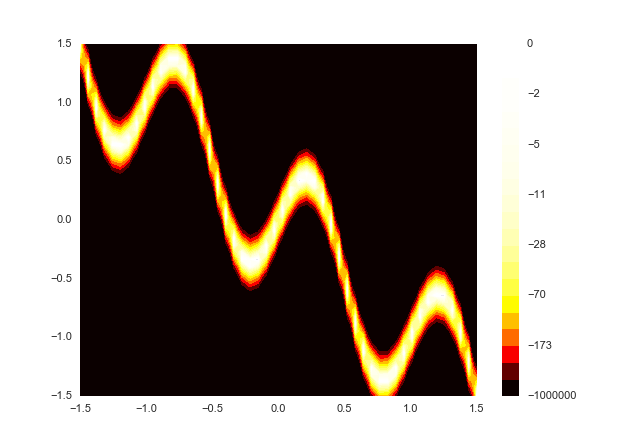

In [21]:
plt.figure()
levels = - np.r_[0, np.logspace(0, 2.5, 20)][::-1]
vmin=levels.min()
vmax=levels.max()
levels = np.r_[-10**6, levels]
plt.contourf(W1, W2, num_posterior2, levels, vmin=vmin, vmax=vmax, cmap=plt.cm.hot)
plt.colorbar()